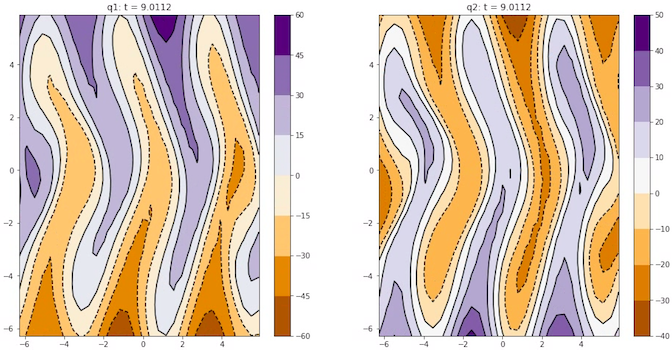

# Lab 5: Baroclinic instability

In this lab we will examine baroclinic instability in a two-layer shallow water QG model. We will examine: 

- counter-propagating Rossby waves
- coupling of the two layers via vortex stretching/squeezing
- the role of the baroclinic shear velocity and the condition for instability

To use this notebook, you will need Python 3 and the latest version of [Dedalus](http://dedalus-project.org/) installed on your local machine. 

# Background

## Two-layer QG equations

We will model baroclinic instability using a two-layer quasigeostrophic model with a rigid lid and a flat bottom. In the lectures, we saw that this model is governed by the following equations of motion

$$
\frac{D q_1}{D t} = 0, \qquad \frac{D q_2}{D t} = 0, 
$$

where $q_1$ and $q_2$ are the QG potential vorticity in the upper and lower layers, respectively, 

$$
q_1 = \nabla^2 \psi_1 + \beta y + \frac{1}{2} k_d^2 \left( \psi_2 - \psi_1 \right),
$$

$$
q_2 = \nabla^2 \psi_2 + \beta y - \frac{1}{2} k_d^2 \left( \psi_2 - \psi_1 \right),
$$

Here, $k_d$ is the inverse of the Rossby deformation scale, $k_d = 1/L_d$. 




## Base state and perturbations

We prescribe a base state with a velocity of $(U, 0)$ in the upper layer and $(-U,0)$ in the lower layer

$$
\overline{\psi_1} = - U y, \qquad \overline{\psi_2} = U y. 
$$

This gives a base state potential vorticity of

$$
\overline{q_1} = \left( \beta + k_d^2 U \right) y, \qquad \overline{q_2} = \left( \beta - k_d^2 U \right) y.
$$

We can see that the potential vorticity gradient in the two layers will have opposite sign only if $k_d^2 U > \beta$. 

Now consider small perturbations to the base state streamfunction and potential vorticity

$$
\psi_1 = \overline{\psi_1} + \psi_1', \qquad q_1 = \overline{q_1} + q_1', \qquad \mbox{where} \qquad q_1' = \nabla^2 \psi_1' + \frac{1}{2} k_d^2 \left( \psi_2' - \psi_1' \right), 
$$

$$
\psi_2 = \overline{\psi_2} + \psi_2', \qquad q_2 = \overline{q_2} + q_2', \qquad \mbox{where} \qquad q_2' = \nabla^2 \psi_2' - \frac{1}{2} k_d^2 \left( \psi_2' - \psi_1' \right),  
$$

Substituting this into the equations of motion in each layer and neglecting nonlinear terms gives

$$
\left( \frac{\partial}{\partial t} + U \frac{\partial}{\partial x} \right) q_1' + \frac{\partial \psi_1'}{\partial x} \left( \beta + k_d^2 U \right) = 0, 
$$

$$
\left( \frac{\partial}{\partial t} - U \frac{\partial}{\partial x} \right) q_2' + \frac{\partial \psi_2'}{\partial x} \left( \beta - k_d^2 U \right) = 0, 
$$


# Experimental set-up

## Libraries

We start by importing the usual libraries for Dedalus, Numpy, and Matplotlib. 

In [1]:
from dedalus import public as de
import numpy as np
import matplotlib.pyplot as plt
from dedalus.extras import flow_tools
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Basis and domains

We will work in a square domain. For simplicity, we will use periodic boundary conditions on each side of the domain. We do this by choosing the basis functions in the $x$ and $y$ directions to be Fourier (sines and cosines). 

In [2]:
# Domain size, resolution, and integration time 
Lx, Ly = 2*np.pi, 2*np.pi
Nx, Ny = 32, 32
T = 10.01

# Basis functions
x_basis = de.Fourier('x', Nx, interval=(-Lx, Lx), dealias=3/2)
y_basis = de.Fourier('y', Ny, interval=(-Ly, Ly), dealias=3/2)
domain  = de.Domain([x_basis,y_basis], np.float64)

# Problem parameters

The problem parameters are
- `beta`: the planetary vorticity gradient $\beta$
- `U`: the background shear flow strength (eastward) $U$ in the upper layer and $-U$ in the lower layer
- `Kd`: the inverse deformation length $K_d = 1/L_d$
- `D`: diffusivity

To start, we will look at the case with no shear, $U = 0$, and no vortex stretching or squeezing, $K_d = 0$. The problem then reduces to two shallow water layers that do not interact. 

In [3]:
# problem parameters

beta = 1.    # planetary vorticity gradient    
D    = 5e-4  # diffusivity 

# Change these parameters to try different experiments

U    = 1.    # shear flow strength
Kd   = 2.    # deformation wavenumber

## Initial value problem

Now we need to tell Dedalus about the domain, variables, parameters, and equations. (We don't need to worry about boundary conditions because they are built into our choice of Fourier basis modes.)

We will define the problem in almost exactly the same way as we did when we simulated Rossby waves: the only difference here is that we now have *two* shallow water layers to simulate. 

In [4]:
# create the initial value problem
problem = de.IVP(domain, variables=['psi1','psi2'])

# declare the problem parameters
problem.parameters['beta'] = beta
problem.parameters['Kd']   = Kd
problem.parameters['U']    = U
problem.parameters['D']    = D

# declare substitutions
problem.substitutions['q1']     = "d(psi1,x=2) + d(psi1,y=2) + Kd**2*(psi2-psi1)/2"
problem.substitutions['q2']     = "d(psi2,x=2) + d(psi2,y=2) - Kd**2*(psi2-psi1)/2"
problem.substitutions['J(f,g)'] = "dx(f)*dy(g) - dy(f)*dx(g)"
problem.substitutions['u']      = "-dy(psi1)"
problem.substitutions['v']      = "dx(psi1)"

# equations of motion
problem.add_equation("dt(q1) + U*dx(q1) + (beta + Kd**2*U)*dx(psi1) - D*d(q1,x=2) - D*d(q1,y=2)= - J(psi1,q1)",condition="(nx!=0) or (ny!=0)")
problem.add_equation("psi1 = 0",condition="(nx==0) and (ny==0)")
problem.add_equation("dt(q2) - U*dx(q2) + (beta - Kd**2*U)*dx(psi2) - D*d(q2,x=2) - D*d(q2,y=2) = - J(psi2,q2)",condition="(nx!=0) or (ny!=0)")
problem.add_equation("psi2 = 0",condition="(nx==0) and (ny==0)")

## Create the solver

In [5]:
solver =  problem.build_solver(de.timesteppers.RK443)

solver.stop_sim_time = T
solver.stop_wall_time = np.inf
solver.stop_iteration = np.inf

initial_dt = 0.2*Lx/Nx
max_dt = 1e-1
cfl = flow_tools.CFL(solver,initial_dt,safety=0.8)
cfl.add_velocities(('u','v'))

2019-04-03 14:31:16,096 pencil 0/1 INFO :: Building pencil matrix 1/16 (~6%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+01/s
2019-04-03 14:31:16,123 pencil 0/1 INFO :: Building pencil matrix 2/16 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+01/s
2019-04-03 14:31:16,180 pencil 0/1 INFO :: Building pencil matrix 4/16 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+01/s
2019-04-03 14:31:16,251 pencil 0/1 INFO :: Building pencil matrix 6/16 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+01/s
2019-04-03 14:31:16,318 pencil 0/1 INFO :: Building pencil matrix 8/16 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+01/s
2019-04-03 14:31:16,389 pencil 0/1 INFO :: Building pencil matrix 10/16 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+01/s
2019-04-03 14:31:16,461 pencil 0/1 INFO :: Building pencil matrix 12/16 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2019-04-03 14:31:16,522 pencil 0/1 INFO :: Building pencil matrix 14/16 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+01/s
2019-04-03 14:31:16,57

## Initial condition

The evolution of the instability does not depend strongly on the choice of initial condition. Here we have chosen an initial small perturbation to the PV in each layers. 

In [6]:
x,y = domain.grids(scales=domain.dealias)

q1_init = domain.new_field()
q1_init.set_scales(domain.dealias,keep_data=False)
q2_init = domain.new_field()
q2_init.set_scales(domain.dealias,keep_data=False)

eps = .3 # initial perturbation strength

q1_init['g'] = eps*np.cos(4*np.pi/Lx*x)*np.exp(-(x**2+y**2)/8)
q2_init['g'] = -eps*np.cos(4*np.pi/Lx*x)*np.exp(-(x**2+y**2)/8)

## Boundary value problem for streamfunction

We are specifying the initial potential vorticity, from which we need to derive the initial streamfunction. We do this by solving a Boundary Value Problem for the initial streamfunction. 

In [7]:
init_problem = de.LBVP(domain, variables=['psi1','psi2'])

# declare the problem parameters
init_problem.parameters['q1_init']   = q1_init
init_problem.parameters['q2_init']   = q2_init
init_problem.parameters['Kd']        = Kd

# boundary value problem
init_problem.add_equation("d(psi1,x=2) + d(psi1,y=2) + Kd**2*(psi2-psi1)/2 = q1_init",condition="(nx!=0) or (ny!=0)")
init_problem.add_equation("d(psi2,x=2) + d(psi2,y=2) - Kd**2*(psi2-psi1)/2 = q2_init",condition="(nx!=0) or (ny!=0)")
init_problem.add_equation("psi1 = 0",condition="(nx==0) and (ny==0)")
init_problem.add_equation("psi2 = 0",condition="(nx==0) and (ny==0)")

In [8]:
# solve for the initial state
init_solver = init_problem.build_solver()
init_solver.solve()
psi1_init = init_solver.state['psi1']
psi1_init.set_scales(domain.dealias, keep_data=False)
psi2_init = init_solver.state['psi2']
psi2_init.set_scales(domain.dealias, keep_data=False)

2019-04-03 14:31:16,628 pencil 0/1 INFO :: Building pencil matrix 1/16 (~6%) Elapsed: 0s, Remaining: 0s, Rate: 8.7e+01/s
2019-04-03 14:31:16,640 pencil 0/1 INFO :: Building pencil matrix 2/16 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 8.5e+01/s
2019-04-03 14:31:16,661 pencil 0/1 INFO :: Building pencil matrix 4/16 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 9.0e+01/s
2019-04-03 14:31:16,699 pencil 0/1 INFO :: Building pencil matrix 6/16 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+01/s
2019-04-03 14:31:16,721 pencil 0/1 INFO :: Building pencil matrix 8/16 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 7.6e+01/s
2019-04-03 14:31:16,749 pencil 0/1 INFO :: Building pencil matrix 10/16 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 7.5e+01/s
2019-04-03 14:31:16,783 pencil 0/1 INFO :: Building pencil matrix 12/16 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+01/s
2019-04-03 14:31:16,812 pencil 0/1 INFO :: Building pencil matrix 14/16 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+01/s
2019-04-03 14:31:16,85

## Plot initial conditions

We can now visualize the streamfunction and potential vorticity. The *total* streamfunction is given by the sum of the base state and the initial perturbation

$$
\psi_1 = \overline{\psi_1} + \psi_1', \qquad \mbox{where} \qquad \overline{\psi_1} = - U \, y,
$$

$$
\psi_2 = \overline{\psi_2} + \psi_2', \qquad \mbox{where} \qquad \overline{\psi_2} = U \, y.
$$

Likewise, the *total* potential vorticity is 

$$
q_1 = \overline{q_1} + q_1', \qquad \mbox{where} \qquad \overline{q_1} = \left( \beta + K_d^2 U \right) \, y,
$$

$$
q_2 = \overline{q_2} + q_2', \qquad \mbox{where} \qquad \overline{q_2} = \left( \beta - K_d^2 U \right) \, y.
$$

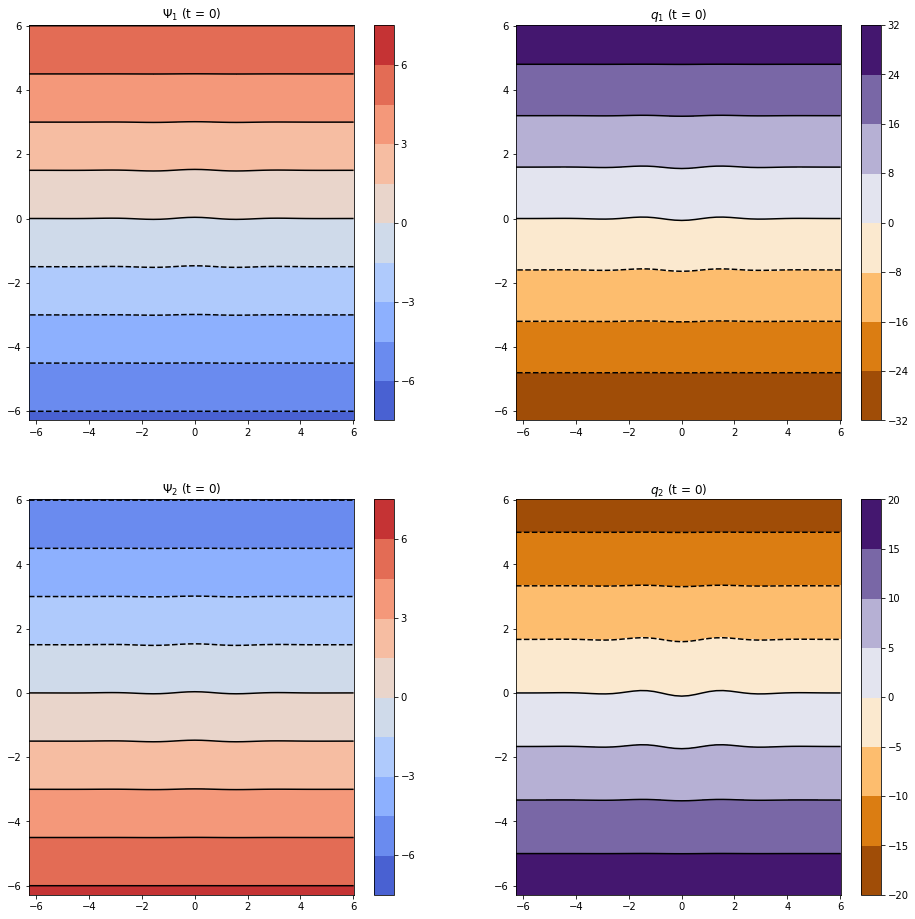

In [9]:
# Plot the initial conditions

xx,yy = np.meshgrid(x,y,indexing='ij')

fig = plt.figure(figsize=(16,16))

ax  = fig.add_subplot(2,2,1)
cax = ax.contourf(xx, yy, psi1_init['g']+U*yy,8,cmap=plt.cm.coolwarm)
dax = ax.contour(xx, yy, psi1_init['g']+U*yy,8,colors='k')
ax.set(title='$\Psi_1$ (t = 0)')
cbar = fig.colorbar(cax)

ax  = fig.add_subplot(2,2,2)
cax = ax.contourf(xx, yy, q1_init['g']+(beta+Kd**2*U)*yy,8,cmap=plt.cm.PuOr)
dax = ax.contour(xx, yy, q1_init['g']+(beta+Kd**2*U)*yy,8,colors='k')
ax.set(title='$q_1$ (t = 0)')
cbar = fig.colorbar(cax)

ax  = fig.add_subplot(2,2,3)
cax = ax.contourf(xx, yy, psi2_init['g']-U*yy,8,cmap=plt.cm.coolwarm)
dax = ax.contour(xx, yy, psi2_init['g']-U*yy,8,colors='k')
ax.set(title='$\Psi_2$ (t = 0)')
cbar = fig.colorbar(cax)

ax  = fig.add_subplot(2,2,4)
cax = ax.contourf(xx, yy, q2_init['g']+(beta-Kd**2*U)*yy,8,cmap=plt.cm.PuOr)
dax = ax.contour(xx, yy, q2_init['g']+(beta-Kd**2*U)*yy,8,colors='k')
ax.set(title='$q_2$ (t = 0)')
cbar = fig.colorbar(cax)

## Analysis

Since our model is evolving the streamfunction `psi` in each layer, we would like to save these fields, along with the potential vorticity `q` and velocities `u` and `v` every few timesteps. These will be saved in a directory `analysis_dir`.  

In addition to snapshots of the streamfunction, velocity, and potential vorticity, we will save time series of the kinetic energy and available potential energy of the perturbations:

$$
KE = \frac{1}{2} \int | \boldsymbol{\nabla} \psi_1' |^2 + | \boldsymbol{\nabla} \psi_2' |^2 \, dA
$$

$$
APE = \int K_d^2 \, \left( \psi_1' - \psi_2' \right)^2 \, dA
$$

In [10]:
# first remove any existing analysis folders
analysis_dir = 'analysis'
import os
import shutil

if os.path.exists(analysis_dir):
    print("Overwriting existing directory " + analysis_dir)
    shutil.rmtree(analysis_dir)

# Create analysis tasks

analysis = solver.evaluator.add_file_handler(analysis_dir, sim_dt=max_dt, max_writes=100)
analysis.add_system(solver.state, layout='g')
analysis.add_task("d(psi1,x=2)+d(psi1,y=2)+Kd**2*(psi2-psi1)", layout='g', name='q1')
analysis.add_task("d(psi2,x=2)+d(psi2,y=2)-Kd**2*(psi2-psi1)", layout='g', name='q2')
analysis.add_task("-dy(psi1)", layout='g', name='u1')
analysis.add_task(" dx(psi1)", layout='g', name='v1')
analysis.add_task("-dy(psi2)", layout='g', name='u2')
analysis.add_task(" dx(psi2)", layout='g', name='v2')
analysis.add_task("integ(0.5*(dx(psi1)*dx(psi1)+dy(psi1)*dy(psi1)+dx(psi2)*dx(psi2)+dy(psi2)*dy(psi2)))",name='KE')
analysis.add_task("integ(Kd**2*(psi1-psi2)*(psi1-psi2))", name='APE')

Overwriting existing directory analysis


## Run the simulation

We are now ready to run the simulation. We call a variables `psi1` and `psi2` and give them the initial values `psi1_init` and `psi2_init`, respectively. Then we run through the main time loop, saving data as we go using the analysis tasks that we defined.  

In [11]:
import time
psi1 = solver.state['psi1']
psi1.set_scales(domain.dealias,keep_data=False)
psi1['g'] = psi1_init['g']
psi2 = solver.state['psi2']
psi2.set_scales(domain.dealias,keep_data=False)
psi2['g'] = psi2_init['g']

# Main loop
start_time = time.time()
while solver.ok:
    dt = min(max_dt,cfl.compute_dt())
    solver.step(dt)
    if solver.iteration % 100 == 0:
        print('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))
end_time = time.time()
print('Runtime:', end_time-start_time)

Iteration: 100, Time: 8.168322e+00, dt: 3.150843e-02
Iteration: 200, Time: 9.691237e+00, dt: 8.508155e-03
2019-04-03 14:31:27,164 solvers 0/1 INFO :: Simulation stop time reached.
Runtime: 9.24512505531311


## Merge the analysis files and read in the data

Dedalus saves the analysis data (snapshots of the flow etc) to a number of subdirectories in the directory `analysis`. In order to plot figures and make movies, we need to merge these files together into a single data set and then read it into memory. 

In [12]:
# Merge the analysis files

import subprocess
from dedalus.tools import post
import pathlib
post.merge_process_files(analysis_dir, cleanup=True)
set_paths = list(pathlib.Path(analysis_dir).glob("analysis_s*.h5"))
post.merge_sets(analysis_dir + "/analysis.h5", set_paths, cleanup=True)

2019-04-03 14:31:27,170 post 0/1 INFO :: Merging files from analysis
2019-04-03 14:31:27,330 post 0/1 INFO :: Creating joint file analysis/analysis.h5


In [13]:
# Read in the data

import h5py

file = h5py.File(analysis_dir + '/analysis.h5','r')
t    = file['/scales/sim_time'][:]
X    = file['/scales/x/1.0'][:]
Y    = file['/scales/y/1.0'][:]
psi1 = file['tasks']['psi1'][:]
q1   = file['tasks']['q1'][:]
psi2 = file['tasks']['psi2'][:]
q2   = file['tasks']['q2'][:]
APE  = file['tasks']['APE'][:]
KE   = file['tasks']['KE'][:]

file.close()

APE = APE[:,0,0]
KE  = KE[:,0,0]

## Plot snapshots of the PV

Now we can plot snapshots of the (total) potential vorticity and save them to a new directory called `plots`. Once we have created the snapshots, we can stitch them together into a movie. 

You can easily adapt this code if you would like to visualize the streamfunction or the velocity fields instead. 

In [ ]:
# first remove any existing plot folders
plot_dir = "plots"
import os
import shutil

if os.path.exists(plot_dir):
    print("Overwriting existing directory " + plot_dir)
    shutil.rmtree(plot_dir)

os.makedirs(plot_dir)

XX,YY = np.meshgrid(X,Y,indexing='ij')

for i in range(len(t)): 

    fig = plt.figure(figsize=(16, 8))
    ax  = fig.add_subplot(1,2,1)
    
    cax = ax.contourf(XX, YY, q1[i,:,:]+(beta+Kd**2*U)*YY,8,cmap=plt.cm.PuOr)
    dax = ax.contour(XX, YY, q1[i,:,:]+(beta+Kd**2*U)*YY,8,colors='k')
    ax.set(title='q1: t = ' + str(round(t[i],4)))
    cbar = fig.colorbar(cax)
    
    ax  = fig.add_subplot(1,2,2)
    cax = ax.contourf(XX, YY, q2[i,:,:]+(beta-Kd**2*U)*YY,8,cmap=plt.cm.PuOr)
    dax = ax.contour(XX, YY, q2[i,:,:]+(beta-Kd**2*U)*YY,8,colors='k')
    ax.set(title='q2: t = ' + str(round(t[i],4)))
    cbar = fig.colorbar(cax)
    
    fig.savefig(plot_dir + '/snap_{:0>3d}.png'.format(i),bbox_inches='tight')
    plt.close()
    if i%10 == 0: 
        print('Saved figure',i)
        
print('Saved snapshots')

Overwriting existing directory plots
Saved figure 0
Saved figure 10
Saved figure 20
Saved figure 30
Saved figure 40
Saved figure 50


In [ ]:
def save_movie(image_filenames,movie_filename,framerate):
    
    # Edits: SG says: This is the orginal line:
    os.system('ffmpeg -r ' + str(framerate) + ' -i ' + image_filenames + ' -vb 20M -vcodec mpeg4 -y ' + movie_filename)
    # This should be better:
    # os.system('ffmpeg -i ' + image_filenames + '-r  ' + str(framerate) + ' -vb 20M -vcodec mpeg4 -y ' + movie_filename)  
    
# make movie
movie_filename = "movie_U_" + str(U) + "_Kd_" + str(Kd) +".mp4"
save_movie(plot_dir + "/snap_%03d.png",movie_filename,10)
print('Created ' + movie_filename)

## Available potential energy and kinetic energy



In [ ]:
fig = plt.figure(figsize=(10, 5))
ax  = plt.axes()
ax.plot(t,APE,label="APE")
ax.plot(t,KE,label="KE")

plt.xlim([0,T])
plt.title(r'Available Potential Energy / Kinetic Energy',fontsize=16)
plt.xlabel(r'Model time',fontsize=16)

plt.legend(loc='lower left',fontsize=16).draw_frame(True)

# Now try it yourself

In each of the following experiments, run the simulation and ask yourself the following questions: 

- Is the shear flow velocity larger than the threshold shear $U_s = \beta / K_d^2$? 
- What is the base state potential vorticity gradient in each layer? Does it change sign?  
- What direction do Rossby waves propagate in each layer?
- Describe and explain what happens to the APE and KE as functions of time. 
- Describe qualitatively how the phases in each layer are related to one another. 

### Experiment 1: no shear flow, no coupling between layers

In the first experiment, there is no shear flow (`U = 0`) and no coupling between the layers via vortex stretching or squeezing (`Kd = 0`). 

### Experiment 2: shear flow, no coupling between layers

Now let's turn on the shear flow. Change the value of the shear flow velocity to `U = 1`. (This gives a base state flow of $U = 1$ in the upper layer and $U = -1$ in the lower layer.) However, we will still ignore coupling between the layers (`Kd = 0`). 

### Experiment 3: shear flow, coupling between layers

Finally, let's turn on the shear flow and the coupling between the layers. Change the value of the shear flow velocity to `U = 1` and the inverse deformation scale to `Kd = 2`.